In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


# Install libraries

In [2]:
%pwd

'/Users/anushk/Desktop/UAD_EDC_DIFF/EDC-master'

In [3]:
!pip install -r colab_requirements.txt

Looking in links: https://download.pytorch.org/whl/torch_stable.html

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/Users/anushk/Desktop/UAD_EDC_DIFF/EDC-master/config.py'>

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

from config import print_config, BASE_DIR, CODE_DIR, DATASET_DIR
print_config()

===== APTOS CONFIGURATION =====
Environment:     local
Device:          mps
Base directory:  /Users/anushk/Desktop/UAD_EDC_DIFF
Code directory:  /Users/anushk/Desktop/UAD_EDC_DIFF/EDC-master
Dataset root:    /Users/anushk/Desktop/UAD_EDC_DIFF/APTOS
Train folder:    /Users/anushk/Desktop/UAD_EDC_DIFF/APTOS/train
Test folder:     /Users/anushk/Desktop/UAD_EDC_DIFF/APTOS/test
Saved models:    /Users/anushk/Desktop/UAD_EDC_DIFF/EDC-master/saved_models


# Preprocessing

In [4]:
!python ./prepare_dataset/prepare_br35h.py --data-folder ../Br35H/original --save-folder ../Br35H

# Dataset Description and Sample Input Images

In [4]:
import os

base_dir = "../APTOS" 

for root, dirs, _ in os.walk(base_dir):
    level = root.replace(base_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}|-- {os.path.basename(root)}/")


|-- APTOS/
    |-- test/
        |-- ABNORMAL/
        |-- NORMAL/
    |-- train/
        |-- NORMAL/


../APTOS/train
../APTOS/test


,Set,Class,Count
0,train,NORMAL,1000
1,test,ABNORMAL,1857
2,test,NORMAL,805



 TRAIN SAMPLES


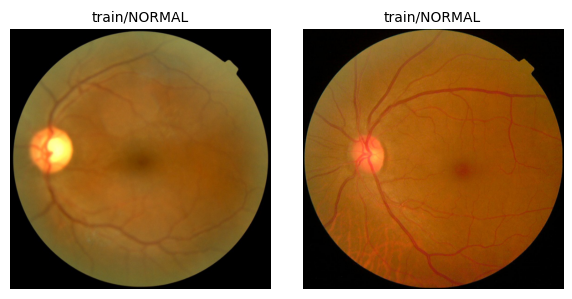


 TEST SAMPLES


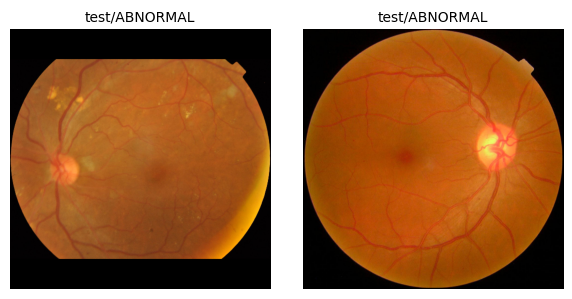

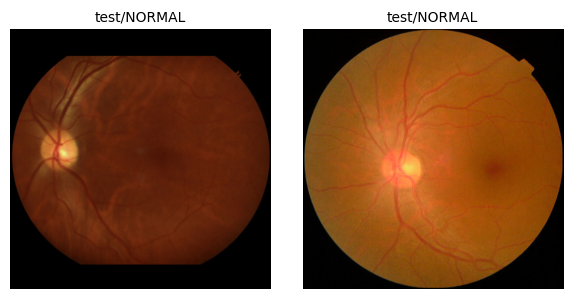

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from IPython.display import display


base_path = "../APTOS"   
sample_count = 2                        

def get_image_counts(base_dir):
    counts = []
    for split in ["train", "test"]:
        split_path = os.path.join(base_dir, split)
        print(split_path)
        if not os.path.exists(split_path):
            print(f"{split_path} does not exist.")
            continue
        for subfolder in sorted(os.listdir(split_path)):
            sub_path = os.path.join(split_path, subfolder)
            if os.path.isdir(sub_path):
                num_images = len([
                    f for f in os.listdir(sub_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                counts.append({"Set": split, "Class": subfolder, "Count": num_images})
    return pd.DataFrame(counts)

def show_random_samples(base_dir, n=2):
    for split in ["train", "test"]:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            continue
        
        print(f"\n {split.upper()} SAMPLES\n" + "="*40)
        for subfolder in sorted(os.listdir(split_path)):
            sub_path = os.path.join(split_path, subfolder)
            if os.path.isdir(sub_path):
                images = [
                    os.path.join(sub_path, f)
                    for f in os.listdir(sub_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ]
                if len(images) == 0:
                    continue
                samples = random.sample(images, min(n, len(images)))

                # Show the images
                fig, axes = plt.subplots(1, len(samples), figsize=(6, 3))
                if len(samples) == 1:
                    axes = [axes]
                for ax, img_path in zip(axes, samples):
                    img = Image.open(img_path)
                    ax.imshow(img)
                    ax.axis("off")
                    ax.set_title(f"{split}/{subfolder}", fontsize=10)
                plt.tight_layout()
                plt.show()

# Show counts
df_counts = get_image_counts(base_path)
display(df_counts)

# Show samples
show_random_samples(base_path, sample_count)


# Training and Testing

In [6]:
## BASELINE EDC WITH LATENT DIFFUSION MODEL
!python edc_aptos.py --data_dir ../APTOS --gpu 0

[2026-01-19 09:47:28,409 WARNING] USE GPU: 0 for training
TrainSet Image Number: 1000
EvalSet Image Number: 2662
=== Train Split ===
Total: 1000
Normal:   1000
Abnormal: 0

=== Eval/Test Split ===
Total: 2662
Normal:   805
Abnormal: 1857
[2026-01-19 09:47:28,949 INFO] Number of Trainable Params: 50079528
[2026-01-19 09:47:28,950 INFO] Using Apple Silicon GPU (MPS backend)
[2026-01-19 09:47:29,301 INFO] model_arch: R50_R50(
  (edc_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (conv2): Conv

In [ ]:
## VISULALIZATION FOR BASELINE EDC
import pickle
import pandas as pd
import os

save_dir = "./saved_models"
save_name = "edcad_aptos_256_r50_r50_m4_bn99_adamw5e4wd1e4_1e5_b32_i1k_cl1_0"
# Load log
save_path = os.path.join(save_dir, save_name, "train_log.pkl")
with open(save_path, "rb") as f:
    logs = pickle.load(f)

# Convert to DataFrame
df = pd.DataFrame(logs)

# List all available metric names
print("=== Available Metrics in Log File ===")
print(df.columns.tolist())

# Show first few rows to see values
print("\n=== Sample Rows ===")
print(df.head())

=== Available Metrics in Log File ===
['train/total_loss', 'train/e1_std', 'train/e2_std', 'train/e3_std', 'lr', 'train/prefecth_time', 'train/run_time', 'eval/loss', 'eval/f1', 'eval/recall', 'eval/specificity', 'eval/acc', 'eval/AUC', 'eval/AUC1', 'eval/AUC2', 'eval/AUC3', 'it']

=== Sample Rows ===
   train/total_loss  train/e1_std  train/e2_std  train/e3_std       lr  \
0          0.498330      0.035483      0.033781      0.026437  0.00001   
1          0.380766      0.035201      0.033699      0.026319  0.00001   
2          0.331602      0.035386      0.033723      0.026278  0.00001   
3          0.302565      0.034927      0.033698      0.026281  0.00001   

   train/prefecth_time  train/run_time  eval/loss   eval/f1  eval/recall  \
0             0.006089        2.314739   0.624865  0.909832     0.961766   
1             0.004945        2.720262   0.475149  0.914182     0.949381   
2             0.005682        2.730462   0.415374  0.928378     0.921379   
3             0.004246

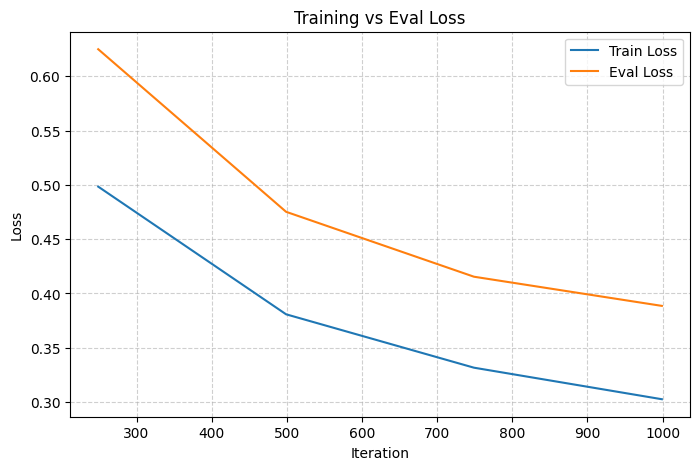

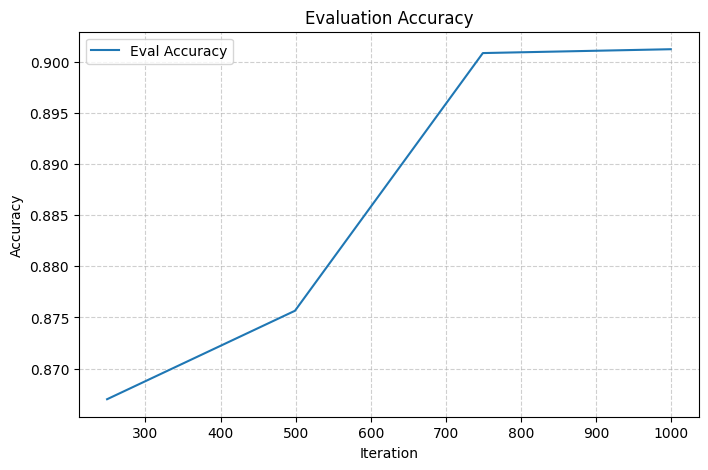

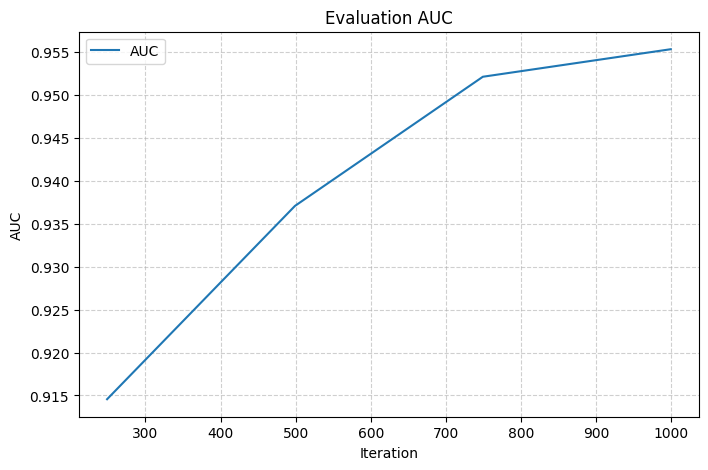

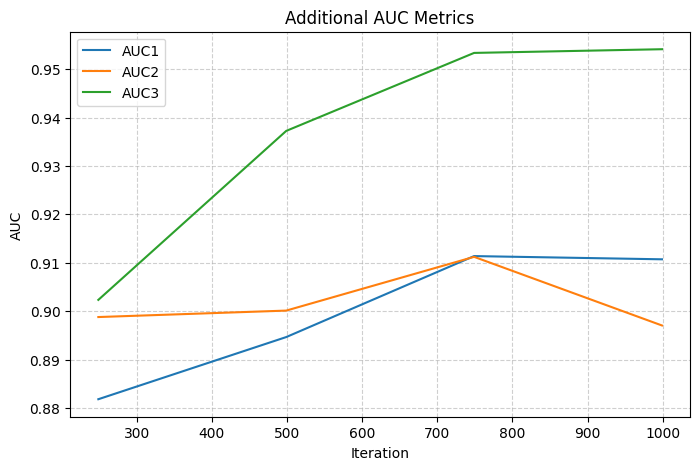

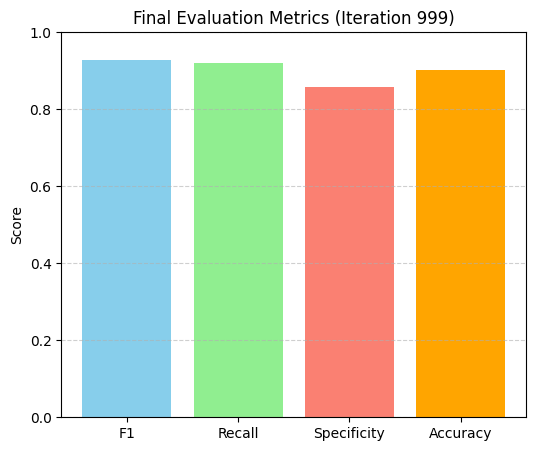

=== Iterations Summary ===
 it  train/total_loss  eval/loss  eval/f1  eval/recall  eval/specificity  eval/acc  eval/AUC
249          0.498330   0.624865 0.909832     0.961766          0.648447  0.867017  0.914562
499          0.380766   0.475149 0.914182     0.949381          0.705590  0.875657  0.937084
749          0.331602   0.415374 0.928378     0.921379          0.853416  0.900826  0.952133
999          0.302565   0.388518 0.928552     0.920302          0.857143  0.901202  0.955341


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

# ====== Load Logs ======
save_dir = "./saved_models"
save_name = "edc_aptos"
save_path = os.path.join(save_dir, save_name, "train_log.pkl")

with open(save_path, "rb") as f:
    logs = pickle.load(f)

df = pd.DataFrame(logs)

# ====== Helper Plot Function ======
def plot_metric(x, y_list, labels, title, ylabel):
    plt.figure(figsize=(8,5))
    for y, label in zip(y_list, labels):
        plt.plot(df[x], df[y], label=label)
    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# ====== 1. Training vs Eval Loss ======
plot_metric("it", ["train/total_loss", "eval/loss"],
            ["Train Loss", "Eval Loss"], "Training vs Eval Loss", "Loss")

# ====== 2. Training vs Eval Accuracy ======
plot_metric("it", ["eval/acc"], ["Eval Accuracy"], "Evaluation Accuracy", "Accuracy")
# (if you had train accuracy logged, add it here as well)

# ====== 3. Evaluation AUC ======
plot_metric("it", ["eval/AUC"], ["AUC"], "Evaluation AUC", "AUC")

# ====== 4. AUC1, AUC2, AUC3 ======
plot_metric("it", ["eval/AUC1", "eval/AUC2", "eval/AUC3"],
            ["AUC1", "AUC2", "AUC3"], "Additional AUC Metrics", "AUC")

# ====== 5. Precision, Recall, Specificity as Bar Chart (last iteration) ======
last_row = df.iloc[-1]
metrics = {
    "F1": last_row["eval/f1"],
    "Recall": last_row["eval/recall"],
    "Specificity": last_row["eval/specificity"],
    "Accuracy": last_row["eval/acc"]
}

plt.figure(figsize=(6,5))
plt.bar(metrics.keys(), metrics.values(), color=["skyblue","lightgreen","salmon","orange"])
plt.title(f"Final Evaluation Metrics (Iteration {int(last_row['it'])})")
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# ====== 6. Summary Table ======
summary = df[["it", "train/total_loss", "eval/loss", "eval/f1", "eval/recall",
              "eval/specificity", "eval/acc", "eval/AUC"]].tail(10)  # last 10 iters
print("=== Iterations Summary ===")
print(summary.to_string(index=False))


In [ ]:
# CHECK DATALEAKAGE
import os
from config import TRAIN_DIR, TEST_DIR
train_dir = TRAIN_DIR
test_dir = TEST_DIR

train_files = set(os.listdir(train_dir))
test_files = set(os.listdir(test_dir))

# Common filenames
common_files = train_files.intersection(test_files)

print(f"🔍 Total train images: {len(train_files)}")
print(f"🔍 Total test images:  {len(test_files)}")
print(f"⚠️  Common filenames:  {len(common_files)}")

if common_files:
    print("🧩 Possible data leakage — these files exist in both sets:")
    for f in list(common_files)[:10]:  # show first 10
        print("  ", f)
else:
    print("✅ No filename overlap detected.")


🔍 Total train images: 1000
🔍 Total test images:  805
⚠️  Common filenames:  0
✅ No filename overlap detected.


In [11]:
# import os
# import shutil

# # ===== CONFIG =====
# SRC_ROOT = "."                  # current directory (EDC-master)
# DST_ROOT = "../EDC_DIFFUSION" # copy created one level above

# # What to copy (folders)
# FOLDERS_TO_COPY = [
#     "methods",
#     "models",
#     "datasets",
#     "prepare_dataset",
# ]

# # What to copy (files)
# FILES_TO_COPY = [
#     "train_utils.py",
#     "utils.py",
#     "custom_writer.py",
#     "config.py",
#     "edc_aptos.py",
#     "colab_requirements.txt",
#     "requirements.txt",
# ]

# # ===== CREATE DEST ROOT =====
# os.makedirs(DST_ROOT, exist_ok=True)

# # ===== COPY FOLDERS =====
# for folder in FOLDERS_TO_COPY:
#     src = os.path.join(SRC_ROOT, folder)
#     dst = os.path.join(DST_ROOT, folder)
#     if os.path.exists(src):
#         shutil.copytree(
#             src, dst,
#             dirs_exist_ok=True,
#             ignore=shutil.ignore_patterns(
#                 "__pycache__", "*.pyc", ".DS_Store", "saved_models", "tb", "*.ipynb"
#             )
#         )
#         print(f"✓ Copied folder: {folder}")
#     else:
#         print(f"⚠️ Folder not found: {folder}")

# # ===== COPY FILES =====
# for file in FILES_TO_COPY:
#     src = os.path.join(SRC_ROOT, file)
#     dst = os.path.join(DST_ROOT, file)
#     if os.path.exists(src):
#         shutil.copy2(src, dst)
#         print(f"✓ Copied file: {file}")
#     else:
#         print(f"⚠️ File not found (skipped): {file}")

# print("\n✅ Done.")
# print(f"Colab-ready copy created at: {os.path.abspath(DST_ROOT)}")


✓ Copied folder: methods
✓ Copied folder: models
✓ Copied folder: datasets
✓ Copied folder: prepare_dataset
✓ Copied file: train_utils.py
✓ Copied file: utils.py
✓ Copied file: custom_writer.py
✓ Copied file: config.py
✓ Copied file: edc_aptos.py
✓ Copied file: colab_requirements.txt
✓ Copied file: requirements.txt

✅ Done.
Colab-ready copy created at: /Users/anushk/Desktop/UAD_EDC_DIFF/EDC_DIFFUSION


## ATTENTION IMPLEMENTATION - DOES NOT WORK

In [ ]:
# ## EDC WITH ATTENTION
# !python edc_aptos_attn.py --data_dir ../APTOS --gpu 0

[2025-11-24 12:23:20,509 WARNING] USE GPU: 0 for training
TrainSet Image Number: 1000
EvalSet Image Number: 2662

=== Train Split ===
Total: 1000
Normal:   1000
Abnormal: 0

=== Eval/Test Split ===
Total: 2662
Normal:   805
Abnormal: 1857

[2025-11-24 12:23:21,035 INFO] Number of Trainable Params: 56771880
[2025-11-24 12:23:21,035 INFO] Using Apple Silicon GPU (MPS backend)
[2025-11-24 12:23:21,209 INFO] Arguments: Namespace(save_dir='./saved_models', save_name='edc_aptos_attn', resume=False, load_path=None, overwrite=True, use_tensorboard=True, epoch=1, num_train_iter=1000, num_eval_iter=250, batch_size=32, eval_batch_size=64, use_attention=True, attn_heads=4, optim='AdamW', lr=0.0005, lr_encoder=1e-05, momentum=0.9, weight_decay=0.0001, amp=False, clip=1, data_dir='../APTOS', dataset='fundus', train_sampler='RandomSampler', img_size=256, num_workers=4, seed=0, gpu=0, c='', device=device(type='mps'))
[2025-11-24 12:23:21,209 INFO] [!] data loader keys: dict_keys(['train', 'eval'])
  0

In [ ]:
# ## VISULALIZATION FOR EDC WITH ATTENTION
# import pickle
# import pandas as pd
# import os

# save_dir = "./saved_models"
# save_name = "edc_aptos_attn"
# # Load log
# save_path = os.path.join(save_dir, save_name, "train_log.pkl")
# with open(save_path, "rb") as f:
#     logs = pickle.load(f)

# # Convert to DataFrame
# df = pd.DataFrame(logs)

# # List all available metric names
# print("=== Available Metrics in Log File ===")
# print(df.columns.tolist())

# # Show first few rows to see values
# print("\n=== Sample Rows ===")
# print(df.head())

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import pickle
# import os

# # ====== Load Logs ======
# save_dir = "./saved_models"
# save_name = "edc_aptos_attn"
# save_path = os.path.join(save_dir, save_name, "train_log.pkl")

# with open(save_path, "rb") as f:
#     logs = pickle.load(f)

# df = pd.DataFrame(logs)

# # ====== Helper Plot Function ======
# def plot_metric(x, y_list, labels, title, ylabel):
#     plt.figure(figsize=(8,5))
#     for y, label in zip(y_list, labels):
#         plt.plot(df[x], df[y], label=label)
#     plt.xlabel("Iteration")
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.legend()
#     plt.grid(True, linestyle="--", alpha=0.6)
#     plt.show()

# # ====== 1. Training vs Eval Loss ======
# plot_metric("it", ["train/total_loss", "eval/loss"],
#             ["Train Loss", "Eval Loss"], "Training vs Eval Loss", "Loss")

# # ====== 2. Training vs Eval Accuracy ======
# plot_metric("it", ["eval/acc"], ["Eval Accuracy"], "Evaluation Accuracy", "Accuracy")
# # (if you had train accuracy logged, add it here as well)

# # ====== 3. Evaluation AUC ======
# plot_metric("it", ["eval/AUC"], ["AUC"], "Evaluation AUC", "AUC")

# # ====== 4. AUC1, AUC2, AUC3 ======
# plot_metric("it", ["eval/AUC1", "eval/AUC2", "eval/AUC3"],
#             ["AUC1", "AUC2", "AUC3"], "Additional AUC Metrics", "AUC")

# # ====== 5. Precision, Recall, Specificity as Bar Chart (last iteration) ======
# last_row = df.iloc[-1]
# metrics = {
#     "F1": last_row["eval/f1"],
#     "Recall": last_row["eval/recall"],
#     "Specificity": last_row["eval/specificity"],
#     "Accuracy": last_row["eval/acc"]
# }

# plt.figure(figsize=(6,5))
# plt.bar(metrics.keys(), metrics.values(), color=["skyblue","lightgreen","salmon","orange"])
# plt.title(f"Final Evaluation Metrics (Iteration {int(last_row['it'])})")
# plt.ylabel("Score")
# plt.ylim(0,1)
# plt.grid(axis="y", linestyle="--", alpha=0.6)
# plt.show()

# # ====== 6. Summary Table ======
# summary = df[["it", "train/total_loss", "eval/loss", "eval/f1", "eval/recall",
#               "eval/specificity", "eval/acc", "eval/AUC"]].tail(10)  # last 10 iters
# print("=== Iterations Summary ===")
# print(summary.to_string(index=False))
